In [2]:
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# helper functions
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import plotly.subplots as sp
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def plot_evaluation_metrics(gpr_model, y_true, y_pred):
    ''' 
        This function will take the gpr model and true values and predicted values to create 
    '''
    # Calculate residuals
    residuals = y_true - y_pred

    # Calculate metrics
    r2 = r2_score(y_true, y_pred)
    log_marginal_likelihood = gpr_model.log_marginal_likelihood(gpr_model.kernel_.theta)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    kernel = gpr_model.kernel_

    # Create subplots with an additional column for metrics
    fig = sp.make_subplots(rows=1, cols=2, column_widths=[0.5, 0.5], subplot_titles=("Residuals", "Predicted vs Actual"))

    # Plot residuals
    fig.add_trace(
        go.Scatter(
            x=y_pred,
            y=residuals,
            mode='markers',
            name='Residuals ',
            marker=dict(color='blue')
        ),
        row=1, col=1
    )
    # Add mean line to residuals plot
    fig.add_trace(
        go.Scatter(
            x=y_pred,
            y=[residuals.mean()]*len(y_pred),
            mode='lines',
            name='Mean Residual',
            line=dict(color='green', dash='dash')
        ),
        row=1, col=1
    )

    # Plot predicted vs actual values
    fig.add_trace(
        go.Scatter(
            x=y_true,
            y=y_pred,
            mode='markers',
            name='Predicted vs Actual ',
            marker=dict(color='red')
        ),
        row=1, col=2
    )
    # Add line y=x to predicted vs actual plot
    fig.add_trace(
        go.Scatter(
            x=y_true,
            y=y_true,
            mode='lines',
            name='y=x line',
            line=dict(color='green', dash='dash')
        ),
        row=1, col=2
    )

    # Add metrics as text in the third column
    metrics_text = f"R-squared: {r2:.2f} | "\
                f"LML: {log_marginal_likelihood:.2f} | "\
                f"MAE: {mae:.2f} | "\
                f"MSE: {mse:.2f} | "\
                f"RMSE: {rmse:.2f} | "\
                #f"Learned kernel: {kernel} |"
    
    fig.add_annotation(dict(font=dict(size=15),
                                        x=0,
                                        y=-0.14,
                                        showarrow=False,
                                        text= metrics_text,
                                        textangle=0,
                                        xanchor='left',
                                        xref="paper",
                                        yref="paper"))
    
    fig.add_annotation(dict(font=dict(size=15),
                                        x=0,
                                        y=1.08,
                                        showarrow=False,
                                        text= f"Learned kernel: {kernel}" ,
                                        textangle=0,
                                        xanchor='left',
                                        xref="paper",
                                        yref="paper"))
        
    
    

    # Update layout
    fig.update_layout(title="Model Evaluation Metrics", height=700)
    fig.update_xaxes(title_text="Predicted Values ", row=1, col=1)
    fig.update_yaxes(title_text="Residuals", row=1, col=1)
    fig.update_xaxes(title_text="Actual Values", row=1, col=2)
    fig.update_yaxes(title_text="Predicted Values", row=1, col=2)
    fig.show()

def plot_gpr_samples_plotly( gpr_model, n_samples):
    '''
        Plots samples from a Gaussian Process Regression model using Plotly. By default plots from a distribution if gpr is not trained.
    '''
    
    x = x = np.linspace(0, 23, 100) # field to draw out prior and posteriors 
    X = x.reshape(-1,1)

    y_mean, y_std = gpr_model.predict( X, return_std=True)
    y_samples = gpr_model.sample_y( X, n_samples)

    fig = go.Figure()

    for idx, single_prior in enumerate(y_samples.T):
        fig.add_trace(
            go.Scatter(
                x=x, y=single_prior, mode="lines", name=f"Sampled function #{idx + 1}"
            )
        )

    fig.add_trace(
        go.Scatter(
            x=x,
            y=y_mean,
            mode="lines",
            line_color="red",
            name="Mean",
            line=dict(dash="dash"),
        )
    )

    fig.add_trace(
        go.Scatter(
            x=x,
            y=y_mean - y_std,
            fill=None,
            mode="lines",
            line_color="rgba(255,0,0,0.1)",
            showlegend=False,
        )
    )

    fig.add_trace(
        go.Scatter(
            x=x,
            y=y_mean + y_std,
            fill="tonexty",
            mode="lines",
            line_color="rgba(173, 216, 230, 0.5)",
            name=r"uncertainty",
        )
    )

    # fig.add_trace(
    #     go.Scatter(
    #         x=X_train.ravel(),
    #         y=y_train.ravel(),
    #         mode='markers',
    #         name="Training Data",
    #         marker=dict(symbol='cross', size=4, color= 'royalblue')
    #     )
    # )
    
    # fig.add_trace(
    #     go.Scatter(
    #         x=X_train.ravel(),
    #         y=y_train.ravel(),
    #         mode='lines',
    #         name="Training Data Signal",
    #         marker=dict(symbol='cross', size=4, color= 'royalblue')
    #     )
    # )
    
    # fig.add_trace(
    #     go.Scatter(
    #         x=X_test.ravel(),
    #         y=y_test.ravel(),
    #         mode='lines+markers',
    #         name="Test Data",
    #         marker=dict(symbol='cross', size=4, color= 'green')
    #     )
    # )

    fig.update_layout(
        xaxis_title="Unix Epoch time",
        yaxis_title="Count",
        height= 800,
    )

    fig.show()

def gpr_train(gpr, x_train, y_train, x_test, y_test):
    '''
        Trains a Gaussian Process Regressor on the given training data and makes predictions on test data. 
    '''
    # Create the GPR model outside this func to have more control over kernels

    # Fit the GPR model to the training data
    gpr.fit(x_train, y_train)
    
    plot_gpr_samples_plotly(gpr, 5,x_train,y_train)
    # Perform predictions using the trained GPR model
    y_pred, y_std = gpr.predict(x_test, return_std=True)
    # y_pred: Predicted target values
    # y_std: Standard deviation of predictions

    # Access learned model properties
    kernel_params = gpr.kernel_  # Learned kernel parameters
    # noise_level = gpr.kernel_.get_params()['k2_noise_level']  # Estimated noise level (if available)
    noise_level = gpr.alpha_  # Estimated noise level (if available)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    lml = gpr.log_marginal_likelihood(gpr.kernel_.theta)

    # evaluation metrics
    print(f"MAE: {mae}") # 
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"R-squared: {r2}")
    print(f"MAPE: {mape}%")
    print(
        f"Kernel parameters after fit: \n{gpr.kernel_} \n"
        f"Log-likelihood: {gpr.log_marginal_likelihood(gpr.kernel_.theta):.3f}\n")

    # Print or analyze the results as needed
    print("Predicted values:", y_pred)
    # print("Prediction uncertainty (std):", y_std)
    print("Learned kernel parameters:", kernel_params)
    # print("Estimated noise level:", noise_level)

    return y_pred, y_std, gpr

In [4]:
from sklearn.gaussian_process.kernels import ExpSineSquared
ex_sin_kernel =  ExpSineSquared(length_scale=1.0,length_scale_bounds=(1e-1, 50) , periodicity=0.5, periodicity_bounds= (1e-1, 50))

length_scale=1.0,
length_scale_bounds=(1e-05, 1e15),
kernel = 1.0 * RBF(
        length_scale=length_scale, length_scale_bounds=length_scale_bounds
    )

gpr = GaussianProcessRegressor(kernel=kernel)

In [5]:
plot_gpr_samples_plotly(gpr,5)

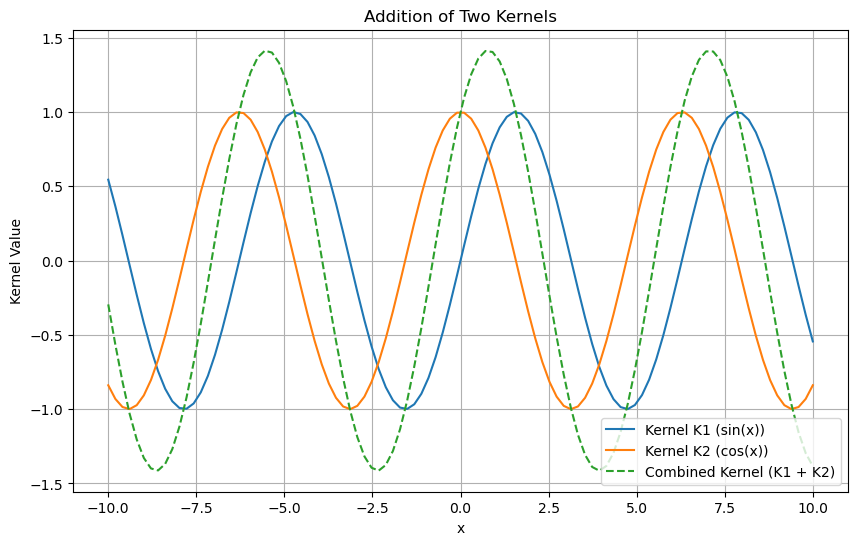

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Generate sample data
x = np.linspace(-10, 10, 100)

# Define two simple kernels
k1 = np.sin(x)
k2 = np.cos(x)

# Perform the addition of the two kernels
k_combined = k1 + k2

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x, k1, label='Kernel K1 (sin(x))')
plt.plot(x, k2, label='Kernel K2 (cos(x))')
plt.plot(x, k_combined, label='Combined Kernel (K1 + K2)', linestyle='--')
plt.title('Addition of Two Kernels')
plt.xlabel('x')
plt.ylabel('Kernel Value')
plt.legend()
plt.grid(True)
plt.show()


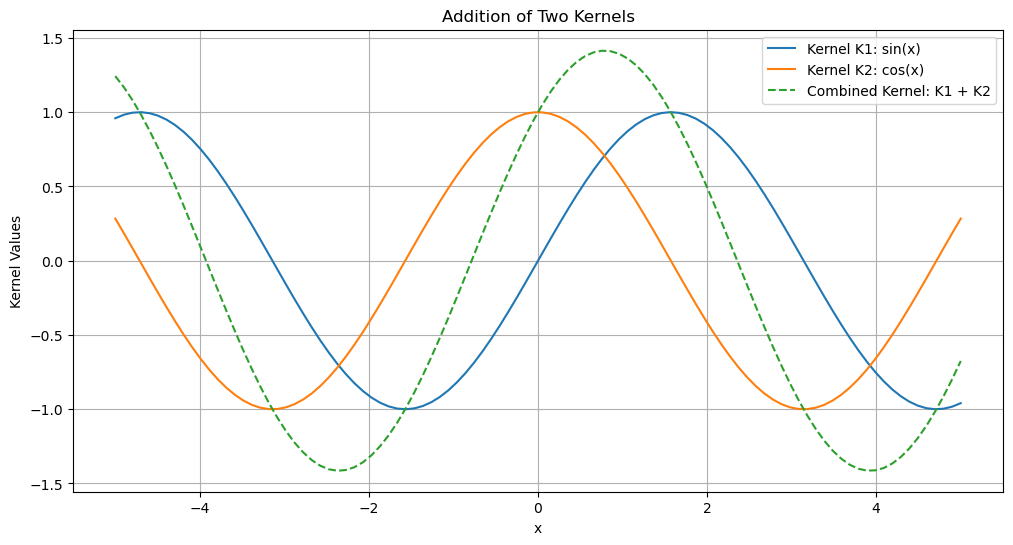

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Define sample data
x = np.linspace(-5, 5, 100)

# Define two kernels
def k1(x):
    return np.sin(x)

def k2(x):
    return np.cos(x)

# Perform addition of kernels
k_combined = k1(x) + k2(x)

# Plotting the kernels and their addition
plt.figure(figsize=(12, 6))
plt.plot(x, k1(x), label='Kernel K1: sin(x)')
plt.plot(x, k2(x), label='Kernel K2: cos(x)')
plt.plot(x, k_combined, label='Combined Kernel: K1 + K2', linestyle='--')
plt.title('Addition of Two Kernels')
plt.xlabel('x')
plt.ylabel('Kernel Values')
plt.legend()
plt.grid(True)
plt.show()


In [12]:

from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ExpSineSquared, ConstantKernel, Exponentiation as C
from helper_functions import *

# Generate sample data
x = np.linspace(0, 10, 100)

# RBF kernel with a length scale of 1.0
k1 = 1 * RBF(length_scale=0.5, length_scale_bounds=(1e-3, 1e3))
# Periodic kernel
k2 = ExpSineSquared(length_scale=1.0,
                    length_scale_bounds=(1e-1, 50) ,
                    periodicity=1,
                    periodicity_bounds= (1e-1, 50))


In [20]:
import plotly.graph_objects as go
import numpy as np
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared

# Generate sample data
x = np.linspace(0, 10, 100).reshape(-1, 1)

# Define the RBF kernel
rbf_kernel = RBF(length_scale=1.0)

# Define the Periodic kernel
periodic_kernel = ExpSineSquared(length_scale=1.0, periodicity=1.0)

# Apply the kernels to the data
k1 = rbf_kernel(x, x)
k2 = periodic_kernel(x, x)

# Perform the addition of the two kernels
k_combined = k1 + k2

# Plotting using Plotly
fig = go.Figure()

# Flatten the x array for plotting
x_flat = x.ravel()

# Adding Kernel K1 (RBF)
fig.add_trace(go.Scatter(x=x_flat, y=k1.diagonal(), mode='lines', name='Kernel K1 (RBF)'))

# Adding Kernel K2 (Periodic)
fig.add_trace(go.Scatter(x=x_flat, y=k2.diagonal(), mode='lines', name='Kernel K2 (Periodic)'))

# Adding Combined Kernel (K1 + K2)
fig.add_trace(go.Scatter(x=x_flat, y=k_combined.diagonal(), mode='lines', name='Combined Kernel (K1 + K2)', line=dict(dash='dash')))

# Updating layout
fig.update_layout(title='Addition of Two Kernels',
                  xaxis_title='x',
                  yaxis_title='Kernel Value',
                  legend_title='Kernels',
                  width=700,
                  height=500)

# Show the figure
fig.show()
